# 卷积神经网络：应用

在本Notebook中，你将会：

- 实现一些辅助函数，这些函数将在你实现PyTorch模型时用到  
- 使用PyTorch实现一个完整的卷积神经网络（ConvNet）

**完成本作业后，你将能够：**

- 使用PyTorch构建并训练一个用于分类问题的卷积神经网络


## PyTorch模型

在上一个作业中，你使用 **numpy** 构建了辅助函数，以便理解卷积神经网络背后的工作机制。  
在当今的实际应用中，大多数深度学习任务都是基于编程框架来实现的，这些框架提供了大量内置函数，可以直接调用。

和往常一样，我们先从导入所需的包开始。
包开始。


### 1 导入库与环境设置

在开始构建和训练卷积神经网络之前，需要导入 Python 标准库、科学计算库以及 PyTorch 库，并设置随机种子保证结果可复现。

In [1]:
# ==============================
# 导入Python标准库和科学计算库
# ==============================
import os
# os：操作系统接口，用于文件路径操作、文件管理等

import math
# math：数学函数库，如开方、对数、三角函数等

import random
# random：生成随机数，控制随机行为

import numpy as np
# numpy：科学计算库，用于数组运算、矩阵操作

import h5py
# h5py：用于读取和写入 HDF5 文件，常用于存储大规模数据集

import matplotlib.pyplot as plt
# matplotlib.pyplot：绘图库，用于绘制各种图形、图像

from PIL import Image
# PIL (Python Imaging Library)：处理图像文件，如打开、保存、转换格式等

# ==============================
# 导入 PyTorch 库
# ==============================
import torch
# PyTorch 主库，用于张量计算和自动微分

import torch.nn as nn
# torch.nn：包含神经网络常用模块，如卷积层、线性层、池化层等

import torch.nn.functional as F
# torch.nn.functional：提供函数式接口，如激活函数、卷积操作、池化操作等

from torch.utils.data import Dataset, DataLoader
# Dataset：抽象数据集类，用于自定义数据集
# DataLoader：数据加载器，将 Dataset 封装成可迭代的批量数据

# ==============================
# Jupyter Notebook 设置
# ==============================
%matplotlib inline
# 在 Jupyter Notebook 中内嵌显示 matplotlib 图像

# ==============================
# 设置随机数种子，保证结果可复现
# ==============================
np.random.seed(1)
# NumPy 随机数种子

random.seed(3)
# Python 内置 random 随机数种子

torch.manual_seed(1)
# PyTorch 随机数种子


### 2 数据加载（Load Dataset）

在训练卷积神经网络之前，我们需要加载训练集和测试集数据。  
本课程使用的 SIGNS 数据集存储为 HDF5 文件，每张图片为 64x64 RGB 图像。

提醒一下，SIGNS 数据集包含 6 个手势，分别表示数字 0 到 5。

<img src="images/SIGNS.png" style="width:800px;height:300px;">


In [2]:
# ==============================
# 数据加载函数
# ==============================
def load_dataset():
    """
    功能：
        从 HDF5 文件中加载训练集和测试集的数据和标签
        
    返回：
        train_set_x_orig -- 训练集特征，shape = (m_train, 64, 64, 3)，每张图片为 64x64 RGB 图像
        train_set_y_orig -- 训练集标签，shape = (m_train,)，整数表示类别
        test_set_x_orig  -- 测试集特征，shape = (m_test, 64, 64, 3)
        test_set_y_orig  -- 测试集标签，shape = (m_test,)
        classes          -- 标签类别数组，shape = (n_classes,)
    """

    # ------------------------------
    # 加载训练集 HDF5 文件
    # ------------------------------
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    # train_dataset: HDF5 文件对象
    # 参数 "datasets/train_signs.h5" 表示文件路径
    # "r" 表示只读模式，不能修改文件内容

    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    # train_dataset["train_set_x"]: HDF5 文件中的训练特征数据集
    # [:] 表示读取整个数据集
    # np.array(...) 将 HDF5 数据转为 numpy 数组，方便后续处理
    # 结果 shape = (m_train, 64, 64, 3)

    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    # train_dataset["train_set_y"]: HDF5 文件中的训练标签数据集
    # np.array(...) 转为 numpy 数组
    # 结果 shape = (m_train,)，每个元素为整数类别

    # ------------------------------
    # 加载测试集 HDF5 文件
    # ------------------------------
    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    # test_dataset: HDF5 文件对象，测试集数据
    # "r" 表示只读模式

    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    # 测试集特征数据，shape = (m_test, 64, 64, 3)

    test_set_y_orig = np.array(test_dataset["test_set_y"][:])
    # 测试集标签数据，shape = (m_test,)

    classes = np.array(test_dataset["list_classes"][:])
    # list_classes: 类别列表，如 [0,1,2,...,5]
    # np.array(...) 转为 numpy 数组，方便索引和分类

    # ------------------------------
    # 返回加载的数据
    # ------------------------------
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


下一个单元格将展示数据集中一个带标签的图像示例。  
你可以自由修改下面的 `index` 值并重新运行，以查看不同的示例。


y = 2


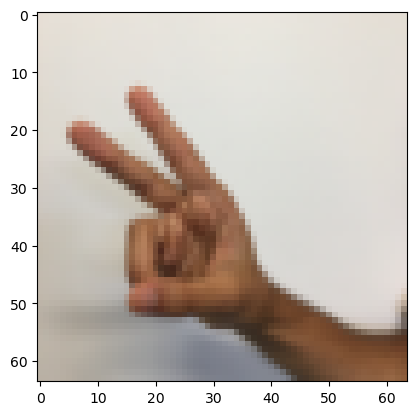

In [3]:
# ==============================
# 展示单张训练图片
# ==============================

# 调用之前定义的 load_dataset() 函数，加载训练集和测试集
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
# X_train_orig: 训练集特征，shape = (m_train, 64, 64, 3)
# Y_train_orig: 训练集标签，shape = (m_train,)
# X_test_orig: 测试集特征，shape = (m_test, 64, 64, 3)
# Y_test_orig: 测试集标签，shape = (m_test,)
# classes: 标签类别数组

# 指定要显示的图片索引
index = 6

# 使用 matplotlib 展示第 index 张训练图片
plt.imshow(X_train_orig[index])
# plt.imshow() 默认接受 (H,W,C) 形状的 RGB 图像

# 打印该图片对应的标签
print("y = " + str(np.squeeze(Y_train_orig[index])))
# np.squeeze() 用于去掉单维度，使输出为标量
# str() 将标签转换为字符串，方便 print 输出
# 输出示例: y = 0

# 显示图片
plt.show()
# plt.show() 会弹出图像窗口或在 Notebook 中显示图像


### 3 定义Dataset（SignsDataset）类

在训练 PyTorch 模型时，通常需要将 NumPy 数组封装成 `Dataset`，然后用 `DataLoader` 迭代 mini-batch。  
下面定义了一个 `SignsDataset` 类，将 SIGNS 数据集转换为 PyTorch Dataset。


In [4]:
# ==============================
# 自定义 Dataset类
# ==============================
class SignsDataset(Dataset):
    """
    功能：
        将 NumPy 数据集封装为 PyTorch Dataset，用于 DataLoader 迭代
        支持图像归一化、通道转换以及可选 transform
    """

    def __init__(self, X_np, Y_np, transform=None):
        """
        初始化 Dataset

        参数：
        X_np     -- NumPy 图像数组，shape = (m,64,64,3)，dtype uint8 或 float32
        Y_np     -- NumPy 标签数组，shape = (m,) 或 (m,1)
        transform-- 可选图像变换（如 torchvision.transforms）
        """

        # ------------------------------
        # 特征数据转换为 float32 类型
        # ------------------------------
        self.X = X_np.astype(np.float32)
        # astype(np.float32)：确保数据类型为 float32，以便后续 PyTorch 计算

        # 如果最大值 > 2.0，说明是原始 0-255 图像，需要归一化到 [0,1]
        if self.X.max() > 2.0:
            self.X = self.X / 255.0

        # ------------------------------
        # PyTorch 要求图像通道在前（C,H,W）
        # ------------------------------
        self.X = np.transpose(self.X, (0,3,1,2))
        # np.transpose：调整数组维度顺序
        # (0,3,1,2) 说明：
        # 0: 样本数 m 不变
        # 3: 通道数 C 从最后一维移到第二维
        # 1: 高度 H
        # 2: 宽度 W
        # 最终 shape = (m,3,64,64)

        # ------------------------------
        # 标签处理
        # ------------------------------
        self.y = np.array(Y_np).reshape(-1).astype(np.int64)
        # reshape(-1)：确保标签为一维向量
        # int64：PyTorch 分类任务要求标签为 long 类型

        # ------------------------------
        # 图像变换（可选）
        # ------------------------------
        self.transform = transform
        # 如果传入 transform（如随机裁剪、旋转等），后续 __getitem__ 会应用

    # ------------------------------
    # 返回样本总数
    # ------------------------------
    def __len__(self):
        return self.X.shape[0]
        # Dataset 长度就是样本数 m

    # ------------------------------
    # 返回单个样本和标签
    # ------------------------------
    def __getitem__(self, idx):
        """
        功能：
            根据索引 idx 返回单个样本图像和标签

        参数：
        idx -- 样本索引，整数

        返回：
        img   -- torch.Tensor 图像，shape = (3,64,64)，dtype float32
        label -- torch.Tensor 标签，dtype long
        """

        # 取第 idx 张图像
        img = self.X[idx]       

        # 取对应标签
        label = self.y[idx]     

        # 如果定义了 transform，应用图像变换
        if self.transform:
            img = self.transform(img)

        # 转换为 PyTorch Tensor
        return torch.from_numpy(img), torch.tensor(label, dtype=torch.long)
    
        # ------------------------------
        # torch.from_numpy(img)
        # 功能：将 NumPy 数组 img 转换为 PyTorch Tensor
        # 输入 img：
        #   - 形状为 (C, H, W)，通道数在前
        #   - 数据类型通常为 float32
        # 输出：
        #   - PyTorch Tensor，保持原数组数据
        #   - 与原 NumPy 数组共享内存，修改 Tensor 会影响原数组
        # 用途：
        #   - PyTorch 模型训练需要 Tensor 输入，而不是 NumPy 数组
        #   - 这里 img 是单张图像，用于 Dataset 返回一个样本
        
        # torch.tensor(label, dtype=torch.long)
        # 功能：将单个标签 label 转换为 PyTorch Tensor
        # 参数：
        #   - label：样本的类别标签（整数）
        #   - dtype=torch.long：指定数据类型为 long (int64)，PyTorch 分类任务要求
        # 输出：
        #   - PyTorch Tensor，形状为标量 ( ) 或 (1,)
        #   - 数据类型为 torch.int64
        # 用途：
        #   - 作为目标标签，输入到分类损失函数 nn.CrossEntropyLoss 时必须是 long 类型


在前面课程中，你已经为该数据集构建了一个全连接网络（fully-connected network）。  
但由于这是图像数据集，更自然的方法是使用卷积神经网络（ConvNet）。状。


### 4 创建Dataset 和 DataLoader

在训练卷积神经网络之前，需要将 NumPy 数据集封装为 `Dataset`，然后使用 `DataLoader` 迭代 mini-batch。



In [5]:
# ==============================
# 创建 Dataset 和 DataLoader
# ==============================

# 定义类别数
num_classes = 6
# 原始脚本中 X_train/X_test 已除以 255，这里在 SignsDataset 内部已做归一化

# 使用自定义 SignsDataset 封装训练集和测试集
train_dataset = SignsDataset(X_train_orig, Y_train_orig)
# train_dataset: 封装训练集的 Dataset 对象，可用于 DataLoader 迭代
test_dataset  = SignsDataset(X_test_orig,  Y_test_orig)
# test_dataset: 封装测试集的 Dataset 对象

# 定义每个 batch 的大小
batch_size = 64

# ------------------------------
# 设置随机种子保证 DataLoader shuffle 可复现
# ------------------------------
g = torch.Generator()   # 创建一个随机数生成器
g.manual_seed(3)        # 设置固定种子 3，确保每次 shuffle 顺序相同

# 创建训练集 DataLoader
train_loader = DataLoader(
    train_dataset,      # 数据集对象
    batch_size=batch_size,  # 每个 batch 的样本数
    shuffle=True,       # 打乱样本顺序
    generator=g         # 使用固定种子生成器，保证可复现
)

# 创建测试集 DataLoader
test_loader  = DataLoader(
    test_dataset,       # 数据集对象
    batch_size=batch_size,  # 每个 batch 的样本数
    shuffle=False       # 测试集不打乱
)



In [6]:
# ------------------------------
# 打印数据集信息
# ------------------------------
print("number of training examples = {}".format(len(train_dataset)))
# len(train_dataset): 返回训练集样本数 m_train

print("number of test examples = {}".format(len(test_dataset)))
# len(test_dataset): 返回测试集样本数 m_test

print("X_train shape: {}".format(X_train_orig.shape))
# X_train_orig.shape: 原始训练集特征 shape = (m_train,64,64,3)

print("Y_train shape: {}".format(Y_train_orig.reshape(-1).shape))
# Y_train_orig.reshape(-1).shape: 转为一维标签向量 shape = (m_train,)

print("X_test shape: {}".format(X_test_orig.shape))
# X_test_orig.shape: 原始测试集特征 shape = (m_test,64,64,3)

print("Y_test shape: {}".format(Y_test_orig.reshape(-1).shape))
# Y_test_orig.reshape(-1).shape: 转为一维标签向量 shape = (m_test,)


number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080,)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120,)


### 5 定义卷积神经网络（ConvNet）

在 PyTorch 中，我们可以使用 `nn.Module` 定义卷积神经网络，并通过 `forward` 方法实现前向传播。  
以下是本作业中网络的结构和对应 PyTorch 实现的说明：

**网络结构**：  
`CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`

具体层参数如下：

- **第一层卷积 (Conv2D)**  
  - 输入通道数: `n_c` (默认 3，RGB 图像)  
  - 输出通道数: 8  
  - 卷积核大小: 4x4  
  - 步长: 1  
  - 填充: SAME (`padding=(kernel_size-1)//2`)  
- **ReLU 激活函数**：`F.relu`  
- **第一层池化 (MaxPool)**  
  - 池化窗口: 8x8  
  - 步长: 8  

- **第二层卷积 (Conv2D)**  
  - 输入通道数: 8  
  - 输出通道数: 16  
  - 卷积核大小: 2x2  
  - 步长: 1  
  - 填充: SAME (`padding=(kernel_size-1)//2`)  
- **ReLU 激活函数**：`F.relu`  
- **第二层池化 (MaxPool)**  
  - 池化窗口: 4x4  
  - 步长: 4  

- **Flatten 展平**：使用 `torch.flatten(x, 1)` 保持 batch-size 不变  
- **全连接层 (Fully Connected)**  
  - 输入特征数: 自动计算 Flatten 后的大小  
  - 输出类别数: `n_y`  

**PyTorch 特性说明**：

- 卷积层和全连接层的权重会自动初始化，但我们在代码中使用了：
  - 卷积层: Kaiming 正态初始化（适合 ReLU）  
  - 全连接层: Xavier 均匀初始化  
- 使用 `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")` 自动选择 GPU 或 del = ConvNet(n_c=3, n_y=num_classes).to(device)
- Fully connected: 输出单元数根据分类任务设置
ng="SAME"  
- ReLU  
- Max po


In [7]:
# ==============================
# 定义卷积神经网络
# ==============================
class ConvNet(nn.Module):
    """
    功能：
        使用 PyTorch 定义卷积神经网络
        网络结构：
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    """
    def __init__(self, n_c=3, n_y=6):
        """
        初始化网络结构

        参数：
        n_c -- 输入图像通道数，默认 RGB=3
        n_y -- 输出类别数，默认 6
        """
        super().__init__()  # 调用父类 nn.Module 初始化

        # ------------------------------
        # 第一层卷积 + 激活 + 池化
        # ------------------------------
        self.conv1 = nn.Conv2d(
            in_channels=n_c,   # 输入通道数
            out_channels=8,    # 卷积核个数 = 输出通道数
            kernel_size=4,     # 卷积核大小 4x4
            stride=1,          # 步幅为 1
            padding=(4-1)//2   # SAME 填充，公式 (k-1)//2
        )
        self.pool1 = nn.MaxPool2d(
            kernel_size=8,     # 池化窗口大小 8x8
            stride=8           # 步幅 8
        )

        # ------------------------------
        # 第二层卷积 + 激活 + 池化
        # ------------------------------
        self.conv2 = nn.Conv2d(
            in_channels=8,     # 输入通道 = conv1 输出通道
            out_channels=16,   # 卷积核个数
            kernel_size=2,     # 卷积核大小 2x2
            stride=1,          # 步幅 1
            padding=(2-1)//2   # SAME 填充
        )
        self.pool2 = nn.MaxPool2d(
            kernel_size=4,     # 池化窗口 4x4
            stride=4           # 步幅 4
        )

        # ==============================
        # 动态计算 flatten 尺寸
        # ==============================
        
        # 构造一个 dummy 输入张量
        # torch.zeros 创建全 0 张量，shape = (1, n_c, 64, 64)
        # 1 表示 batch_size=1，仅用于计算尺寸
        # n_c = 输入通道数（RGB=3）
        # H=W=64 为图片高度和宽度
        dummy = torch.zeros(1, n_c, 64, 64)
        
        # ------------------------------
        # 第一层卷积 + ReLU 激活 + 池化
        # ------------------------------
        # self.conv1(dummy)      -> 卷积操作
        # F.relu(...)            -> ReLU 激活
        # self.pool1(...)        -> 最大池化
        # 输出 shape = (1, 8, H1, W1)，H1/W1 自动计算
        dummy = self.pool1(F.relu(self.conv1(dummy)))
        
        # ------------------------------
        # 第二层卷积 + ReLU 激活 + 池化
        # ------------------------------
        # self.conv2(dummy)      -> 卷积操作
        # F.relu(...)            -> ReLU 激活
        # self.pool2(...)        -> 最大池化
        # 输出 shape = (1, 16, H2, W2)，H2/W2 自动计算
        dummy = self.pool2(F.relu(self.conv2(dummy)))
        
        # ------------------------------
        # 计算 flatten 后的元素总数
        # ------------------------------
        # torch.Tensor.numel() 返回张量所有元素数量
        # flatten_size 用作全连接层输入维度
        self.flatten_size = dummy.numel()


        # ------------------------------
        # 全连接层
        # ------------------------------
        self.fc1 = nn.Linear(
            in_features=self.flatten_size,  # 输入特征数 = flatten_size
            out_features=n_y                # 输出类别数
        )

        # ------------------------------
        # 权重初始化
        # ------------------------------
        self._init_weights()

    def _init_weights(self):
        """
        功能：
            自定义神经网络各层权重和偏置的初始化方法
        """
        
        # 遍历模型的所有模块（卷积层、全连接层等）
        for m in self.modules():
            
            # ------------------------------
            # 卷积层权重初始化
            # ------------------------------
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_：Kaiming He 正态分布初始化
                # 参数解释：
                #   m.weight           -> 当前卷积层的权重张量
                #   mode="fan_out"     -> 按输出通道数调整方差
                #   nonlinearity="relu"-> 适配 ReLU 激活函数
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                
                # 如果卷积层有偏置，则将偏置初始化为 0
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
            # ------------------------------
            # 全连接层权重初始化
            # ------------------------------
            elif isinstance(m, nn.Linear):
                # nn.init.xavier_uniform_：Xavier 均匀分布初始化
                # 参数解释：
                #   m.weight -> 当前全连接层的权重张量
                nn.init.xavier_uniform_(m.weight)
                
                # 偏置初始化为 0
                nn.init.constant_(m.bias, 0)
    

    def forward(self, x):
        """
        前向传播函数

        参数：
        x -- 输入 Tensor，shape = (batch_size, n_c, H, W)

        返回：
        输出 logits，shape = (batch_size, n_y)
        """
        x = F.relu(self.conv1(x))   # conv1 + ReLU
        x = self.pool1(x)           # pool1
        x = F.relu(self.conv2(x))   # conv2 + ReLU
        x = self.pool2(x)           # pool2
        x = torch.flatten(x, 1)     # flatten，保持 batch 维度不变
        x = self.fc1(x)             # 全连接层输出
        return x


### 6 设置设备（CPU 或 GPU）

在 PyTorch 中，训练模型时可以选择使用 **CPU** 或 **GPU**。  
GPU 通常可以大幅加快训练速度。


In [8]:
# ==============================
# 设置设备（CPU 或 GPU）
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# torch.cuda.is_available(): 检查 GPU 是否可用
# 如果 GPU 可用，使用 cuda，否则使用 cpu

Using device: cpu


### 7 创建模型实例

在定义好卷积神经网络后，需要实例化模型，并将其移动到指定设备（CPU 或 GPU）。


In [9]:
# ==============================
# 创建模型实例并移动到设备
# ==============================
model = ConvNet(n_c=3, n_y=num_classes).to(device)
# n_c=3: 输入通道 RGB
# n_y=num_classes: 输出类别数
# .to(device): 将模型移动到指定设备

### 8 定义损失函数和优化器

在训练神经网络时，需要定义 **损失函数**（衡量预测与真实标签的差距）和 **优化器**（更新模型参数的方法）= 0.009
函数实现损失计算。


In [10]:
# ==============================
# 定义损失函数和优化器
# ==============================

# ------------------------------
# 学习率
# ------------------------------
learning_rate = 0.009
# 学习率 lr，用于控制每次梯度更新的步长
# 在训练过程中，可以调整 lr 来加快收敛或防止震荡

# ------------------------------
# 损失函数
# ------------------------------
criterion = nn.CrossEntropyLoss()
# nn.CrossEntropyLoss() 用于多分类任务
# 期望输入 logits (未经过 softmax) 形状 = (batch_size, n_classes)
# 标签应为类别索引（long 类型），而非 one-hot
# 内部会自动计算 softmax + 负对数似然 loss

# ------------------------------
# 优化器
# ------------------------------
optimizer = torch.optim.Adam(
    model.parameters(),  # 需要更新的模型参数
    lr=learning_rate     # 学习率
)
# Adam 优化器：结合了动量和 RMSProp 的自适应学习率方法
# model.parameters(): 返回模型所有可训练参数
# lr: 控制每次更新步长


### 9 训练模型

我们将把前面实现的 `ConvNet` 类和 DataLoader 整合起来，构建一个完整的模型，并在 SIGNS 数据集上进行训练。

#### 初始化
- 参数初始化已在 `ConvNet` 类中完成：
  - 卷积层：Kaiming 初始化  
  - 全连接层：Xavier 初始化  

#### 训练步骤
1. 将模型移动到设备（CPU 或 GPU）  
2. 定义损失函数，例如 `nn.CrossEntropyLoss()`  
3. 定义优化器，例如 `torch.optim.Adam`  
4. 进入训练循环：
   - 设置模型为训练模式：`model.train()`  
   - 遍历每个 mini-batch：
     - 将特征和标签移动到设备并确保类型正确  
     - 梯度清零：`optimizer.zero_grad()`  
     - 前向传播：`outputs = model(batch_X)`  
     - 计算损失：`loss = criterion(outputs, batch_Y)`  
     - 反向传播：`loss.backward()`  
     - 参数更新：`optimizer.step()`  
     - 累计损失，计算每个 epoch 的平均损失  

#### 绘制训练损失曲线
训练完成后，可以使用 `matplotlib` 绘制每个 epoch 的平均损失，观察模型收敛情况。


当前是第 0 代，成本值为：1.816834
当前是第 5 代，成本值为：1.461537
当前是第 10 代，成本值为：1.152509
当前是第 15 代，成本值为：0.993058
当前是第 20 代，成本值为：0.902933
当前是第 25 代，成本值为：0.827916
当前是第 30 代，成本值为：0.785316
当前是第 35 代，成本值为：0.758824
当前是第 40 代，成本值为：0.716205
当前是第 45 代，成本值为：0.702879
当前是第 50 代，成本值为：0.669558
当前是第 55 代，成本值为：0.669936
当前是第 60 代，成本值为：0.643852
当前是第 65 代，成本值为：0.636624
当前是第 70 代，成本值为：0.629207
当前是第 75 代，成本值为：0.614305
当前是第 80 代，成本值为：0.641507
当前是第 85 代，成本值为：0.625789
当前是第 90 代，成本值为：0.590561
当前是第 95 代，成本值为：0.578437
当前是第 100 代，成本值为：0.575499
当前是第 105 代，成本值为：0.641166
当前是第 110 代，成本值为：0.562856
当前是第 115 代，成本值为：0.557199
当前是第 120 代，成本值为：0.535619
当前是第 125 代，成本值为：0.556480
当前是第 130 代，成本值为：0.585302
当前是第 135 代，成本值为：0.535300
当前是第 140 代，成本值为：0.522492
当前是第 145 代，成本值为：0.510977


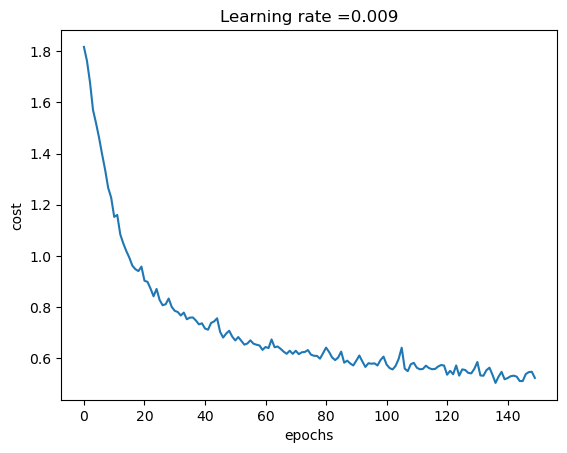

In [11]:
# ==============================
# 训练 ConvNet 模型
# ==============================

num_epochs = 150      # 训练总轮数
print_cost = True     # 是否打印每隔几轮的损失
costs = []            # 用于记录每一轮的平均损失

# ------------------------------
# 开始训练循环
# ------------------------------
for epoch in range(num_epochs):
    model.train()         # 设置模型为训练模式（启用 Dropout/BatchNorm）
    epoch_loss = 0.0      # 累计当前 epoch 的损失
    num_minibatches = 0   # 当前 epoch 的小批量数量计数器

    # --------------------------
    # 遍历训练数据 DataLoader
    # batch_X: batch 图像，shape = (batch_size,3,64,64)
    # batch_Y: batch 标签，shape = (batch_size,)
    # --------------------------
    for batch_X, batch_Y in train_loader:
        # 将数据移动到设备，并确保类型正确
        batch_X = batch_X.to(device, dtype=torch.float)  # 特征为浮点数
        batch_Y = batch_Y.to(device, dtype=torch.long)   # 标签为长整数

        # --------------------------
        # 梯度初始化
        # --------------------------
        optimizer.zero_grad()  # 将上一轮的梯度清零，避免累加

        # --------------------------
        # 前向传播
        # --------------------------
        outputs = model(batch_X)         # 模型输出 logits，shape = (batch_size, n_y)

        # --------------------------
        # 计算损失
        # --------------------------
        loss = criterion(outputs, batch_Y)  # CrossEntropyLoss

        # --------------------------
        # 反向传播
        # --------------------------
        loss.backward()    # 计算梯度

        # --------------------------
        # 参数更新
        # --------------------------
        optimizer.step()   # 使用 Adam 更新参数

        # --------------------------
        # 累计损失和小批量数量
        # --------------------------
        epoch_loss += loss.item()  # 将当前 batch 损失累加到 epoch_loss
        num_minibatches += 1       # 小批量计数加 1

    # ------------------------------
    # 计算当前 epoch 的平均损失
    # ------------------------------
    minibatch_cost = epoch_loss / (num_minibatches if num_minibatches>0 else 1)

    # ------------------------------
    # 每隔 5 代打印一次损失
    # ------------------------------
    if print_cost and (epoch % 5 == 0):
        print(f"当前是第 {epoch} 代，成本值为：{minibatch_cost:.6f}")

    # ------------------------------
    # 将每轮平均损失存入列表
    # ------------------------------
    costs.append(minibatch_cost)

# ==============================
# 绘制训练损失曲线
# ==============================
plt.plot(np.squeeze(costs))           # np.squeeze 去掉多余维度
plt.ylabel('cost')                    # y 轴标签
plt.xlabel('epochs')                  # x 轴标签
plt.title("Learning rate =" + str(learning_rate))  # 图标题
plt.show()


### 10 评估模型准确率

在训练完成后，我们需要评估模型在训练集或测试集上的表现。  中，可以定义一个函数 `evaluate_accuracy` 来计算分类准确率。
#
### 功能
- 遍历给定的 DataLoader  
- 前向传播计算每个样本的预测类别  
- 统计预测正确的样本数  
- 返回准确率（0~1）

### PyTorch 特点
- 使用 `model.eval()` 将模型设置为评估模式，关闭 Dropout/BatchNorm 等训练行为  
- 使用 `torch.no_grad()` 禁用梯度计算，提高推理效率  
- 使用 `torch.argmax(outputs, dim X_batch.to(device, dtype=torch.float)


In [12]:
# ==============================
# 定义函数：评估训练集或测试集准确度
# ==============================
def evaluate_accuracy(loader, model, device):
    """
    功能：
        计算给定数据集在指定模型上的分类准确率

    参数：
        loader -- PyTorch DataLoader，提供批量数据
        model  -- 已训练的模型（ConvNet 实例）
        device -- 设备信息（CPU 或 GPU）
    
    返回：
        accuracy -- 数据集准确率（0~1）
    """

    # ------------------------------
    # 将模型设置为评估模式
    # ------------------------------
    model.eval()  # 关闭 Dropout/BatchNorm 等训练专用行为

    # ------------------------------
    # 初始化统计变量
    # ------------------------------
    correct = 0  # 正确预测样本计数
    total = 0    # 总样本数

    # ------------------------------
    # 禁用梯度计算，提高推理效率
    # ------------------------------
    with torch.no_grad():
        # 遍历 DataLoader 的每一个 batch
        for X_batch, Y_batch in loader:
            # --------------------------
            # 将 batch 数据移动到指定设备
            # --------------------------
            X_batch = X_batch.to(device, dtype=torch.float)  # 输入特征
            Y_batch = Y_batch.to(device, dtype=torch.long)   # 标签（类别索引）

            # --------------------------
            # 前向传播，得到 logits
            # --------------------------
            outputs = model(X_batch)  # shape = (batch_size, n_y)

            # --------------------------
            # 取每个样本预测概率最大的类别
            # --------------------------
            preds = torch.argmax(outputs, dim=1)  # shape = (batch_size,)

            # --------------------------
            # 累加正确预测数量
            # --------------------------
            correct += (preds == Y_batch).sum().item()

            # 累加总样本数
            total += Y_batch.size(0)

    # ------------------------------
    # 计算准确率
    # ------------------------------
    return correct / total if total > 0 else 0.0
    # 返回准确率（0~1），total=0 时避免除以 0


In [13]:
# ==============================
# 计算训练集和测试集的准确度
# ==============================

# ------------------------------
# 调用 evaluate_accuracy 计算训练集准确率
# train_loader: 训练集 DataLoader
# model: 已训练的模型
# device: 运行设备（CPU 或 GPU）
# ------------------------------
train_accuracy = evaluate_accuracy(train_loader, model, device)

# ------------------------------
# 调用 evaluate_accuracy 计算测试集准确率
# test_loader: 测试集 DataLoader
# ------------------------------
test_accuracy  = evaluate_accuracy(test_loader, model, device)

# ------------------------------
# 打印训练集和测试集准确率
# {:.4f} 保留四位小数
# ------------------------------
print("训练集准确度：{:.4f}".format(train_accuracy))
print("测试集准确度：{:.4f}".format(test_accuracy))


训练集准确度：0.8167
测试集准确度：0.6917


恭喜！你已经完成了本程序，并构建了一个可以识别手语（SIGN language）的模型，在测试集上的准确率接近 69%。  

如果你愿意，可以进一步探索这个数据集。  
通过调整超参数或使用正则化（因为该模型明显存在高方差问题），你实际上可以提高模型的准个赞！👍


恭喜！你已经完成了本程序，并构建了一个可以识别手语（SIGN language）的模型，在测试集上的准确率接近 69%。  

如果你愿意，可以进一步探索这个数据集。  
通过调整超参数或使用正则化（因为该模型明显存在高方差问题），你实际上可以提高模型的准确率。
